# LinkedIn Job Postings

## ADS 508 Impacting the Business with a Distributed Data Science Pipeline

In [3]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
import sagemaker
from pyathena import connect
import awswrangler as wr
from collections import Counter
from wordcloud import WordCloud
import pandas as pd
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

## Data Ingestion

### CSV to S3

In [4]:
# Setup boto3 session parameters
session = sagemaker.Session()
bucket = session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

# Establish connection
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [5]:
# Set S3 Source Location (Public bucket)
s3_public_path = "s3://linkedin-postings"

In [6]:
%store s3_public_path

Stored 's3_public_path' (str)


In [7]:
# Set S3 Destination Location (Private bucket)
s3_private_path = "s3://{}/linkedin_data".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-937572952481/linkedin_data


In [8]:
%store s3_private_path

Stored 's3_private_path' (str)


In [9]:
# Copy data from Public S3 bucket to Private S3 bucket
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "postings/postings.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "salaries/salaries.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "job_skills/job_skills.csv"

copy: s3://linkedin-postings/postings/postings.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/postings/postings.csv
copy: s3://linkedin-postings/salaries/salaries.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/salaries/salaries.csv
copy: s3://linkedin-postings/job_skills/job_skills.csv to s3://sagemaker-us-east-1-937572952481/linkedin_data/job_skills/job_skills.csv


In [10]:
# Check files are copied successfully to private bucket
!aws s3 ls $s3_private_path/

                           PRE job_skills/
                           PRE postings/
                           PRE salaries/


In [ ]:
# Initialize boto3 client
s3 = boto3.client('s3')

# Define bucket and paths 
bucket_name = bucket
file_key = 'linkedin_data/postings/postings.csv'
cleaned_file_key = 'linkedin_data/postings/cleaned_postings.csv'

# Read postings.csv directly from private bucket
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df = pd.read_csv(obj['Body'])

# Remove embedded newlines
df.replace({r'[\n\r]+': ' '}, regex=True, inplace=True)

# Save cleaned CSV back to S3 directly (in-memory)
csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)

s3.put_object(Bucket=bucket_name, Key=cleaned_file_key, Body=csv_buffer.getvalue())

print(f"Cleaned CSV successfully uploaded to: s3://{bucket_name}/{cleaned_file_key}")


### Create Athena Database 

In [11]:
ingest_create_athena_db_passed = False

In [12]:
ingest_create_athena_table_passed = False

In [13]:
database_name = "linkedin_data"

In [14]:
# Set S3 staging directory - a temporary directory for Athena queries
s3_staging_dir = "s3://{}/athena/staging".format(bucket)

In [15]:
# Connect to staging directory
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [16]:
# Create Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)

pd.read_sql(statement, conn)

""


### Verify database has been created

In [17]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,database_name
0,default
1,dsoaws
2,linkedin_data


In [18]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena Tables from CSV Files

In [19]:
table_name = 'postings'
postings_path = "s3://{}/linkedin_data/postings/".format(bucket)

drop_statement = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name)

print(drop_statement)
pd.read_sql(drop_statement, conn)
print("Attempted to Drop {} table".format(table_name))

DROP TABLE IF EXISTS linkedin_data.postings;
Attempted to Drop postings table


In [20]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        company_name string,
        title string,
        description string,
        max_salary float,
        pay_period string,
        location string,
        company_id float,
        views float,
        med_salary float,
        min_salary float,
        formatted_work_type string,
        applies float,
        original_listed_time float,
        remote_allowed float,
        job_posting_url string,
        application_url string,
        application_type string,
        expiry float,
        closed_time float,
        formatted_experience_level string,
        skills_desc string,
        listed_time string,
        posting_domain string,
        sponsored int,
        work_type string,
        currency string,
        compensation_type string,
        normalized_salary float,
        zip_code int,
        fips int
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name, postings_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created postings table")

Created postings table


In [21]:
table_name_2 = "salaries"
salaries_path = "s3://{}/linkedin_data/salaries/".format(bucket)

drop_statement2 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_2)

print(drop_statement2)
pd.read_sql(drop_statement2, conn)
print("Attempted to Drop {} table".format(table_name_2))

DROP TABLE IF EXISTS linkedin_data.salaries;
Attempted to Drop salaries table


In [22]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        salary_id int,
        job_id string,
        max_salary float,
        med_salary float,
        min_salary float,
        pay_period string,
        currency string,
        compensation_type string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_2, salaries_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created salaries table")

Created salaries table


In [23]:
table_name_3 = "job_skills"
job_skills_path = "s3://{}/linkedin_data/job_skills/".format(bucket)

drop_statement3 = """DROP TABLE IF EXISTS {}.{};""".format(database_name, table_name_3)

print(drop_statement3)
pd.read_sql(drop_statement3, conn)
print("Attempted to Drop {} table".format(table_name_3))

DROP TABLE IF EXISTS linkedin_data.job_skills;
Attempted to Drop job_skills table


In [24]:
# SQL statement to execute the postings table
statement = """
    CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        job_id string,
        skill_abr string
    ) 
    ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
    LOCATION '{}' 
    TBLPROPERTIES ('skip.header.line.count'='1')
    """.format(database_name, table_name_3, job_skills_path)

# Execute statement
pd.read_sql(statement, conn)
print("Created job_skills table")

Created job_skills table


### Verify tables have been created successfully

In [25]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

,tab_name
0,job_skills
1,postings
2,salaries


In [26]:
if table_name in df_show.values:
    ingest_create_athena_table_passed = True

In [27]:
# View postings table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name)

pd.read_sql(statement, conn)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,Job SummaryOur office in San Diego is looking ...,institutional and industrial clients. The rol...,directing designers & other disciplines,as well as personally performing engineering ...,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,In This Role,You WillProvide a superior level of technical...,providing technical and project control direc...,and mentoring to other engineers and designer...,None,and initiate solutions to complex problems re...,along with discipline-specific analytical too...,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,You will be a great fit if you have the follow...,providing comprehensive HVAC,Control Systems,Plumbing and Fire Protection engineering serv...,None,contribute to,and carry out strategies to manage our relati...,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Location: San Diego,CATravel: Local travel may be required.,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Equal Opportunity Employment StatementSalas O’...,colour,religion,age,None,national origin,disability status,None,None,None,...,130000.0,Full-time,9.0,None,,https://www.linkedin.com/jobs/view/3898181225/...,,None,None,None


In [28]:
# View salaries table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_2)

pd.read_sql(statement, conn)

,salary_id,job_id,max_salary,med_salary,min_salary,pay_period,currency,compensation_type
0,1,3884428798,NaN,20.0,NaN,HOURLY,USD,BASE_SALARY
1,2,3887470552,25.0,NaN,23.0,HOURLY,USD,BASE_SALARY
2,3,3884431523,120000.0,NaN,100000.0,YEARLY,USD,BASE_SALARY
3,4,3884911725,200000.0,NaN,10000.0,YEARLY,USD,BASE_SALARY
4,5,3887473220,35.0,NaN,33.0,HOURLY,USD,BASE_SALARY


In [29]:
# View job skills table to check the data looks correct
statement = """SELECT * FROM {}.{} LIMIT 5""".format(database_name, table_name_3)

pd.read_sql(statement, conn)

,job_id,skill_abr
0,3884428798,MRKT
1,3884428798,PR
2,3884428798,WRT
3,3887473071,SALE
4,3887465684,FIN


## Data Exploration

In [35]:
postings_df = wr.athena.read_sql_query("""SELECT * FROM postings""", database=database_name)

In [32]:
salaries_df = wr.athena.read_sql_query("""SELECT * FROM salaries""", database=database_name)

In [33]:
job_skills_df = wr.athena.read_sql_query("""SELECT * FROM job_skills""", database=database_name)

### postings EDA

In [39]:
# Basic info
postings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3383601 entries, 0 to 3383600
Data columns (total 31 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   job_id                      string 
 1   company_name                string 
 2   title                       string 
 3   description                 string 
 4   max_salary                  float32
 5   pay_period                  string 
 6   location                    string 
 7   company_id                  float32
 8   views                       float32
 9   med_salary                  float32
 10  min_salary                  float32
 11  formatted_work_type         string 
 12  applies                     float32
 13  original_listed_time        float32
 14  remote_allowed              float32
 15  job_posting_url             string 
 16  application_url             string 
 17  application_type            string 
 18  expiry                      float32
 19  closed_time          

In [40]:
# Missing values
missing_values = postings_df.isnull().sum()
print(missing_values[missing_values > 0])

company_name                  2407600
title                         2565529
description                   2692562
max_salary                    3376835
pay_period                    2922736
location                      2986391
company_id                    3357464
views                         3356053
med_salary                    3366815
min_salary                    3360886
formatted_work_type           3155060
applies                       3358500
original_listed_time          3365225
remote_allowed                3369892
job_posting_url               3207000
application_url               3214578
application_type              3221603
expiry                        3366259
closed_time                   3365454
formatted_experience_level    3237403
skills_desc                   3240461
listed_time                   3243202
posting_domain                3245285
sponsored                     3372331
work_type                     3249654
currency                      3251087
compensation

In [41]:
# Duplicates
duplicates = postings_df.duplicated().sum()
print(duplicates)

2543626


In [42]:
# Summary statistics for numerical columns
print(postings_df.describe())

         max_salary    company_id         views   med_salary    min_salary  \
count  6.766000e+03  2.613700e+04  2.754800e+04      16786.0  2.271500e+04   
mean   1.788823e+09  1.357642e+08  6.450581e+07    4921023.0  3.851685e+11   
std    5.508709e+10  1.498440e+10  1.031686e+10   17750858.0  7.152047e+11   
min    0.000000e+00  0.000000e+00  0.000000e+00          0.0  0.000000e+00   
25%    2.008900e+04  4.000000e+00  1.000000e+01          5.0  3.000000e+00   
50%    2.471345e+05  2.600000e+01  2.499500e+03         80.0  2.700000e+01   
75%    1.059908e+07  8.700000e+04  9.000000e+04      85632.0  1.074613e+07   
max    1.713554e+12  1.713392e+12  1.712351e+12  102368944.0  1.713573e+12   

            applies  original_listed_time  remote_allowed        expiry  \
count  2.510100e+04          1.837600e+04    1.370900e+04  1.734200e+04   
mean            inf          7.892738e+11    6.527129e+11           inf   
std             NaN          8.539566e+11    8.320078e+11           NaN 

In [43]:
# Top 10 unique values in categorical columns
categorical = ["title", "company_name", "location", "formatted_work_type", "formatted_experience_level"]
for col in categorical:
    print(postings_df[col].value_counts().head(10))

title
             49349
 religion    15295
YEARLY        8674
 color        8636
HOURLY        6696
 Inc."        4909
 vision       3235
 dental       2836
 Vision       2070
 gender       1848
Name: count, dtype: Int64
company_name
                       45589
 color                 20362
 dental                 5712
 Dental                 4510
 religion               2403
 Skills                 1598
 but not limited to     1458
 race                   1318
 Inc.                   1251
 skills                 1175
Name: count, dtype: Int64
location
4.0                    13031
                       12529
 national origin        9688
3.0                     7325
5.0                     6733
2.0                     6026
 gender identity        4480
 sexual orientation     4216
 age                    3875
6.0                     3673
Name: count, dtype: Int64
formatted_work_type
                        24420
Full-time                6778
1.0                      4453
1713398400000.

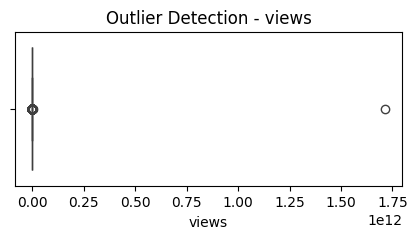

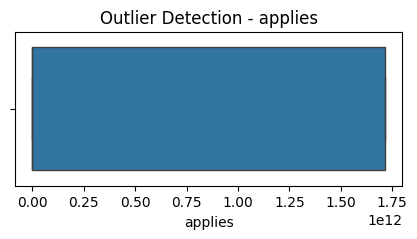

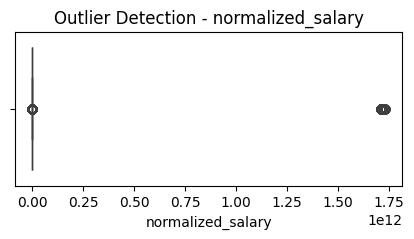

In [74]:
# Detect Outliers using box plots
numerical = ["views", "applies", "normalized_salary"]
for col in numerical:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=postings_df[col])
    plt.title(f"Outlier Detection - {col}")
    plt.show()

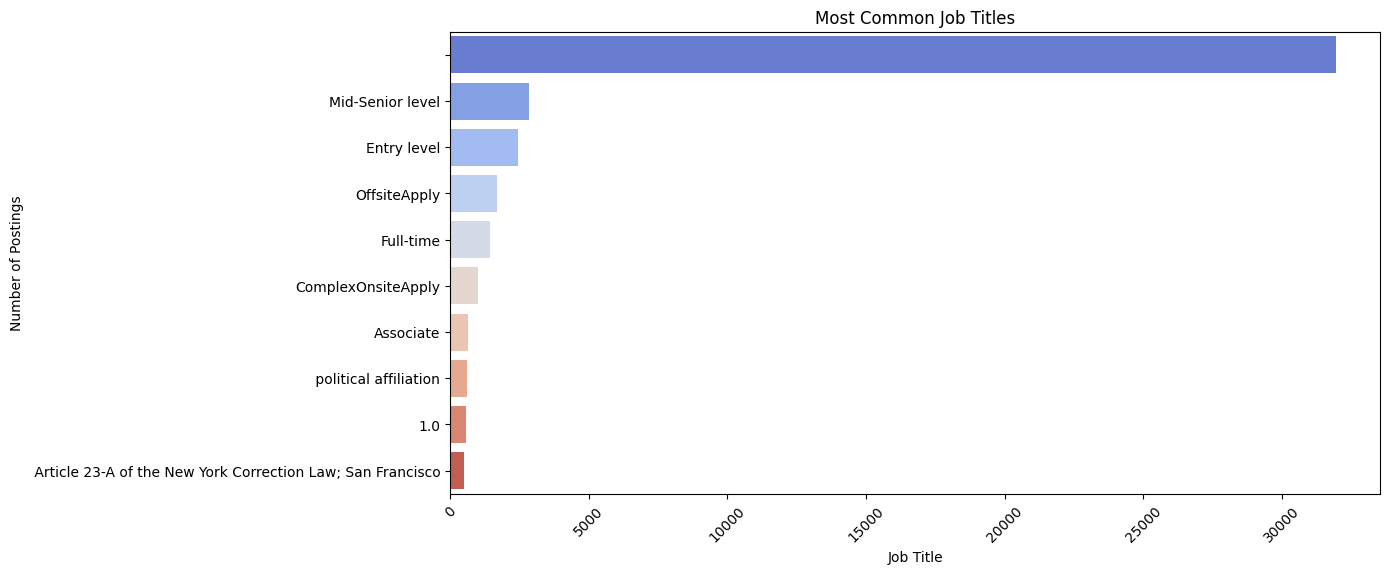

In [44]:
# Visualize most common job titles
top_titles = postings_df["formatted_experience_level"].value_counts().head(10)

plt.figure(figsize=(12,6))
sns.barplot(y=top_titles.index, x=top_titles.values, palette="coolwarm")
plt.xlabel("Job Title")
plt.ylabel("Number of Postings")
plt.title("Most Common Job Titles")
plt.xticks(rotation=45)
plt.show()

### salaries EDA

In [47]:
# Basic stats
print(salaries_df.describe())
print(salaries_df.info())

          salary_id    max_salary     med_salary    min_salary
count       40785.0  3.394700e+04    6838.000000  3.394700e+04
mean        20393.0  9.620987e+04   21370.296875  6.508541e+04
std    11773.759701  6.587374e+05   51338.566406  4.650612e+05
min             1.0  1.000000e+00       0.000000  1.000000e+00
25%         10197.0  5.000000e+01      18.500000  3.900000e+01
50%         20393.0  8.500000e+04      25.000000  6.230000e+04
75%         30589.0  1.425000e+05    2207.000000  1.000000e+05
max         40785.0  1.200000e+08  750000.000000  8.500000e+07
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40785 entries, 0 to 40784
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary_id          40785 non-null  Int32  
 1   job_id             40785 non-null  string 
 2   max_salary         33947 non-null  float32
 3   med_salary         6838 non-null   float32
 4   min_salary         33947 non-nul

In [49]:
# Missing values
salaries_df.isnull().sum()

salary_id                0
job_id                   0
max_salary            6838
med_salary           33947
min_salary            6838
pay_period               0
currency                 0
compensation_type        0
dtype: int64

In [50]:
# Duplicates
salaries_df.duplicated().sum()

0

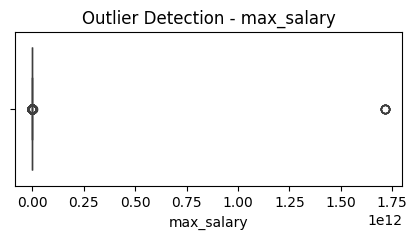

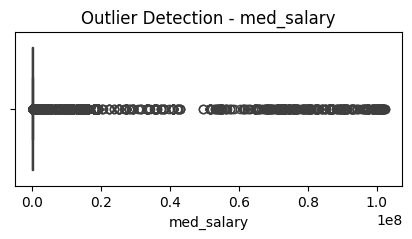

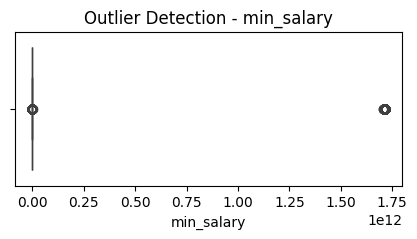

In [51]:
# Detect Outliers using box plots
numerical = ["max_salary", "med_salary", "min_salary"]
for col in numerical:
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=postings_df[col])
    plt.title(f"Outlier Detection - {col}")
    plt.show()

In [52]:
# Salary distributions
salary_columns = ["min_salary", "med_salary", "max_salary"]
print(salaries_df[salary_columns].describe())

         min_salary     med_salary    max_salary
count  3.394700e+04    6838.000000  3.394700e+04
mean   6.508541e+04   21370.296875  9.620987e+04
std    4.650612e+05   51338.566406  6.587374e+05
min    1.000000e+00       0.000000  1.000000e+00
25%    3.900000e+01      18.500000  5.000000e+01
50%    6.230000e+04      25.000000  8.500000e+04
75%    1.000000e+05    2207.000000  1.425000e+05
max    8.500000e+07  750000.000000  1.200000e+08


array([[<Axes: title={'center': 'salary_id'}>,
        <Axes: title={'center': 'max_salary'}>],
       [<Axes: title={'center': 'med_salary'}>,
        <Axes: title={'center': 'min_salary'}>]], dtype=object)

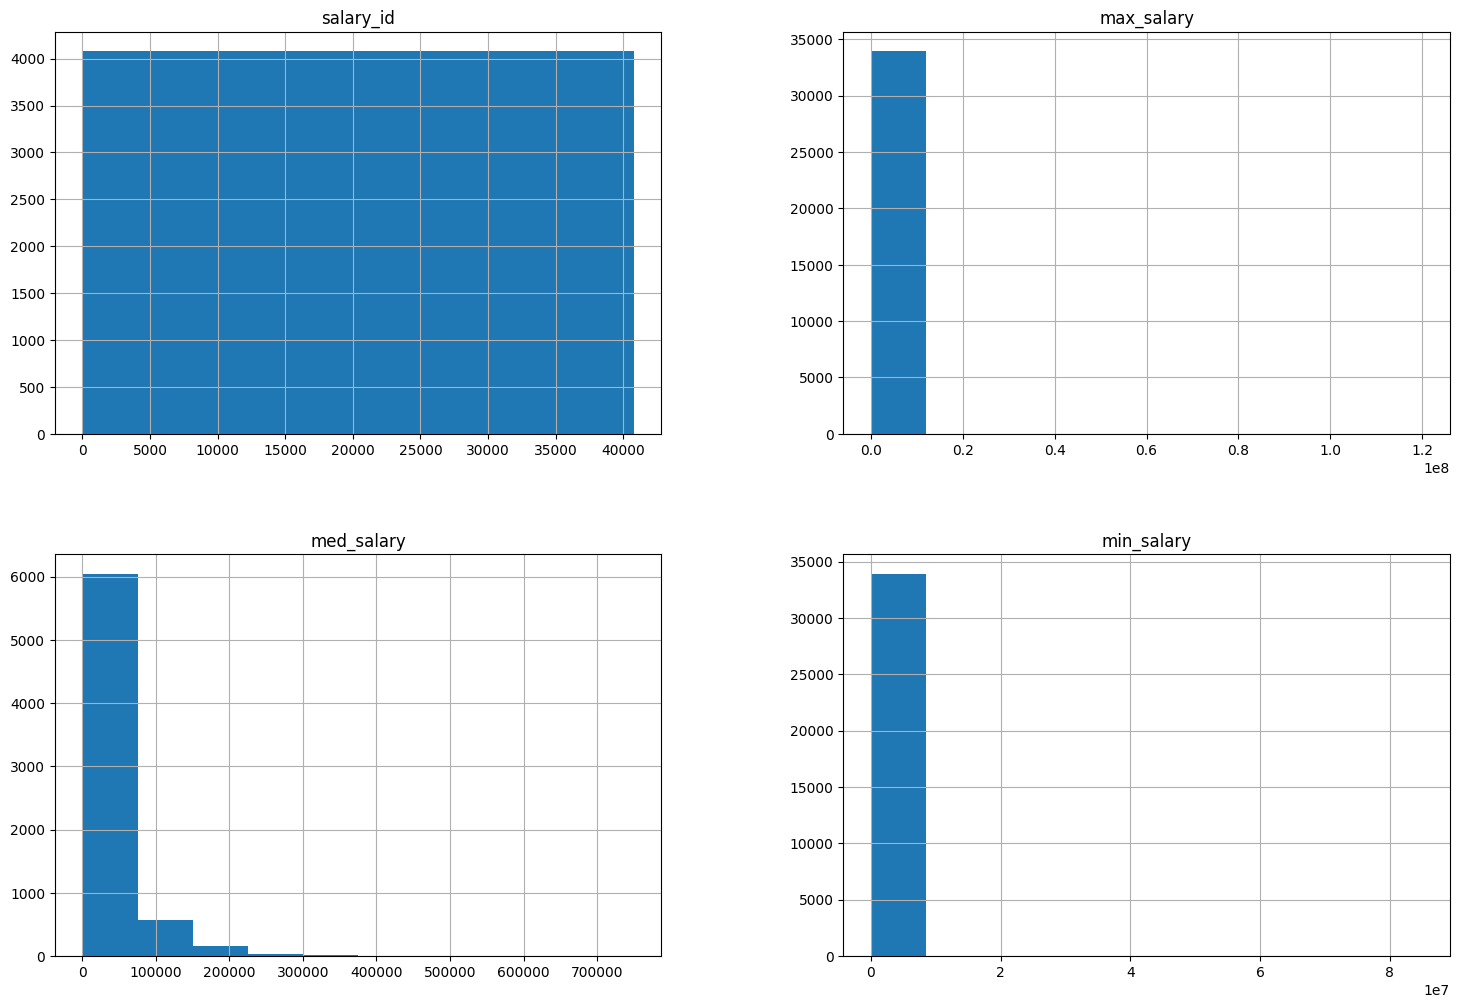

In [76]:
salaries_df.hist(figsize=(18,12))

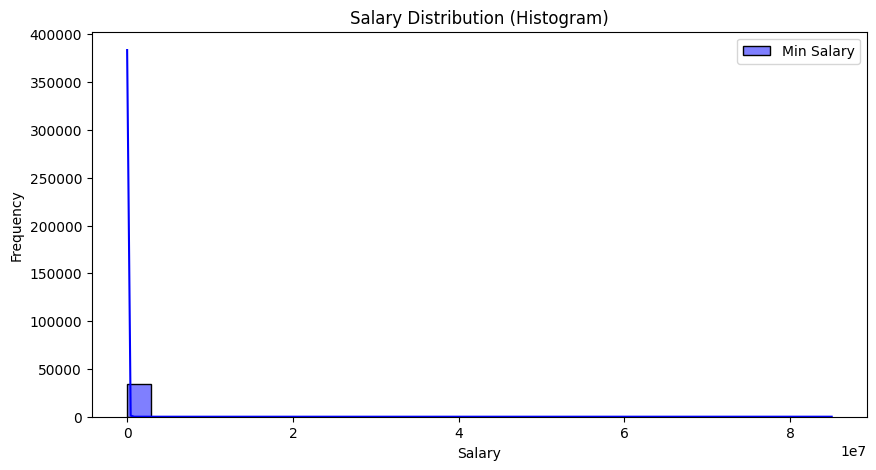

In [61]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["min_salary"], color="blue", kde=True, label="Min Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

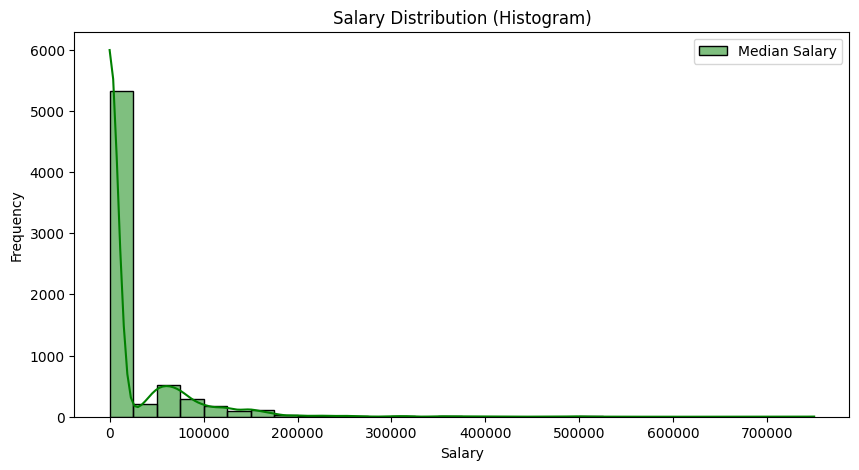

In [59]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["med_salary"], color="green", kde=True, label="Median Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

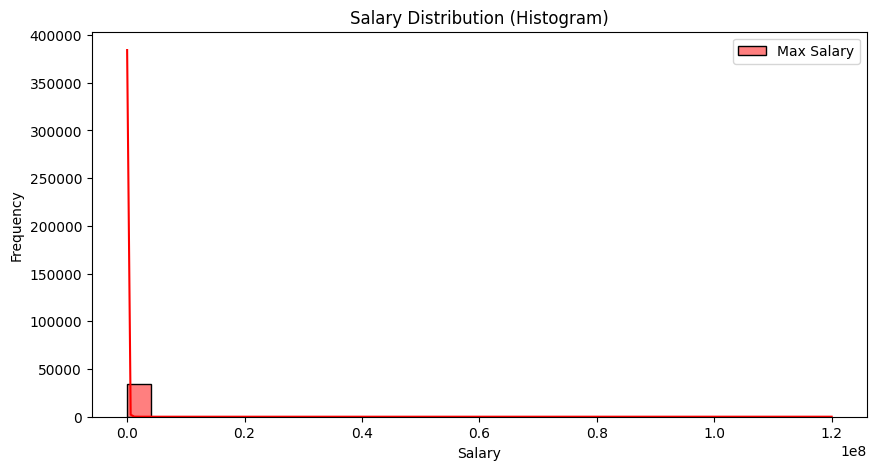

In [60]:
plt.figure(figsize=(10, 5))
sns.histplot(salaries_df["max_salary"], color="red", kde=True, label="Max Salary", bins=30)

# Customize plot
plt.title("Salary Distribution (Histogram)")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### job_skills EDA

In [67]:
# Basic info
print(job_skills_df.describe())
print(job_skills_df.info())

            job_id skill_abr
count       213768    213768
unique      126807        35
top     3891086966        IT
freq             3     26137
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213768 entries, 0 to 213767
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   job_id     213768 non-null  string
 1   skill_abr  213768 non-null  string
dtypes: string(2)
memory usage: 3.3 MB
None


In [64]:
# Missing values
job_skills_df.isnull().sum()

job_id       0
skill_abr    0
dtype: int64

In [65]:
# Duplicates
job_skills_df.duplicated().sum()

0

In [68]:
# Unique skills
print(f"Unique Job Skills: {job_skills_df['skill_abr'].nunique()}")

Unique Job Skills: 35


In [69]:
# Skill frequencies
job_skills_df["skill_abr"] = job_skills_df["skill_abr"].astype(str)  # Ensure it's a string
skills = job_skills_df["skill_abr"].str.split(",").explode().str.strip().value_counts()
print(skills.head(20))

skill_abr
IT      26137
SALE    22475
MGMT    20861
MNFC    18185
HCPR    17369
BD      14290
ENG     13009
OTHR    12608
FIN      8540
MRKT     5525
ACCT     5461
ADM      4860
CUST     4292
PRJM     3997
ANLS     3858
RSCH     2986
HR       2647
LGL      2371
CNSL     2338
EDU      2290
Name: count, dtype: int64


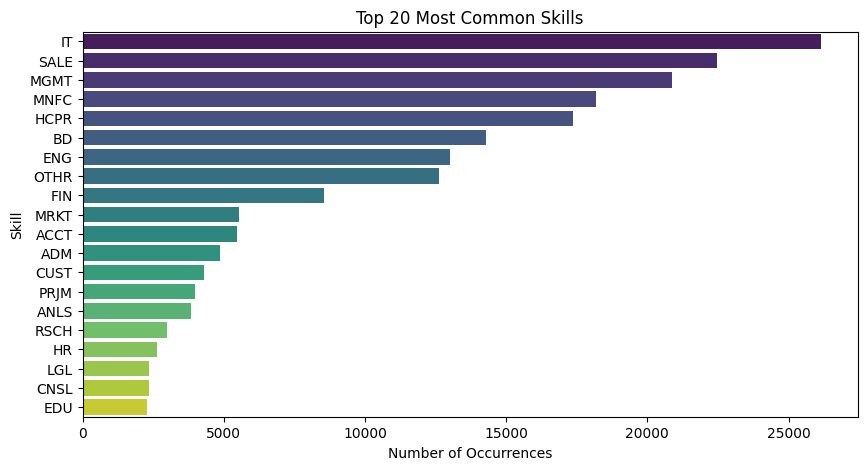

In [70]:
# Concatenate all skills descriptions
all_skills = " ".join(job_skills_df["skill_abr"].dropna())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_skills)

# Bar Chart of Top 20 Most Common Skills
top_skills = skills.head(20)

plt.figure(figsize=(10, 5))
sns.barplot(y=top_skills.index, x=top_skills.values, palette="viridis")
plt.title("Top 20 Most Common Skills")
plt.xlabel("Number of Occurrences")
plt.ylabel("Skill")
plt.show()

### Bias Analysis

In [ ]:
# Salary Bias 
plt.figure(figsize=(12, 6))
sns.boxplot(data=postings_df, x="formatted_experience_level", y="normalized_salary", palette="coolwarm")
plt.title("Salary Distribution by Experience Level")
plt.xlabel("Experience Level")
plt.ylabel("Normalized Salary")
plt.xticks(rotation=45)
plt.show()